Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training model with RandomizedSearchCV...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
170 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py",

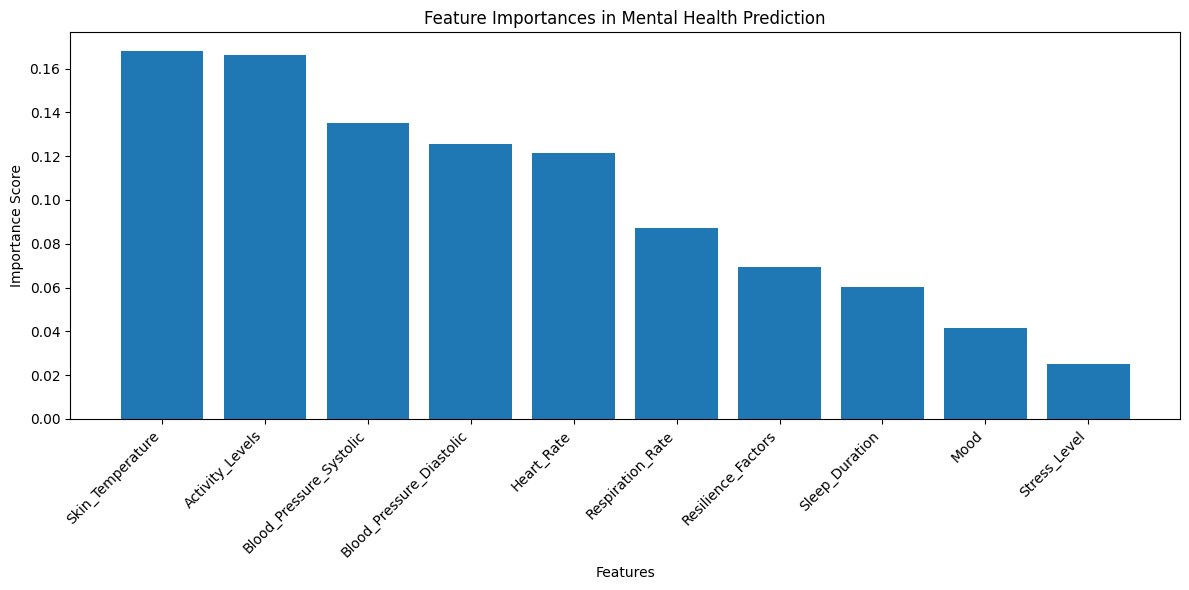

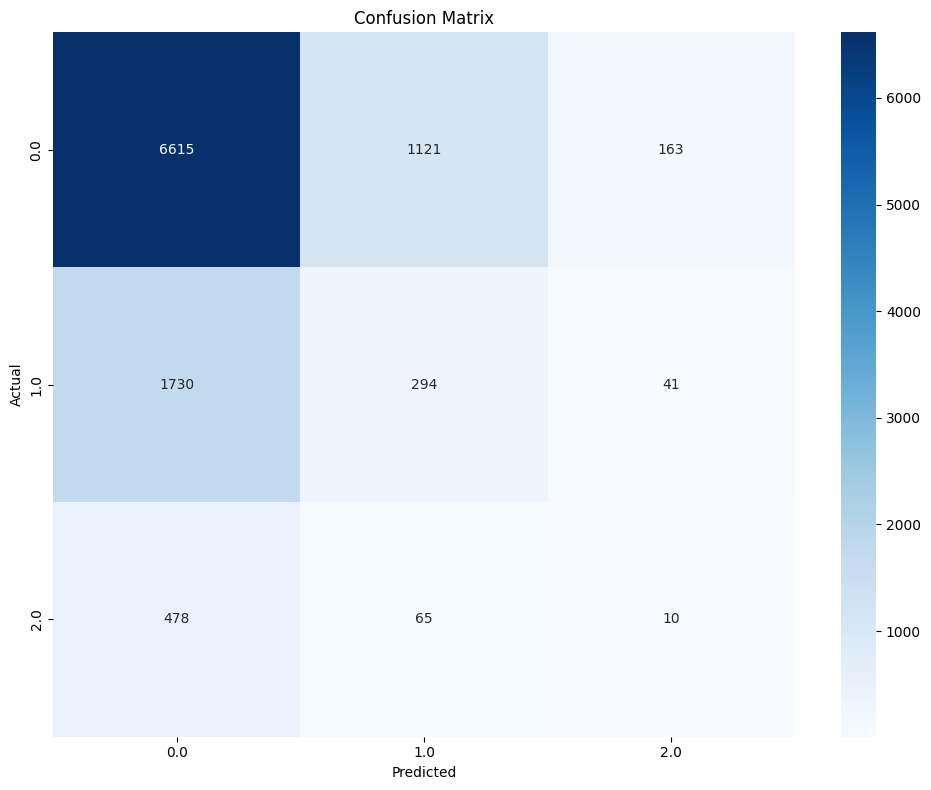


Best Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 14, 'min_samples_split': 15, 'n_estimators': 325}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79      7899
         1.0       0.20      0.14      0.17      2065
         2.0       0.05      0.02      0.03       553

    accuracy                           0.66     10517
   macro avg       0.33      0.33      0.33     10517
weighted avg       0.60      0.66      0.63     10517



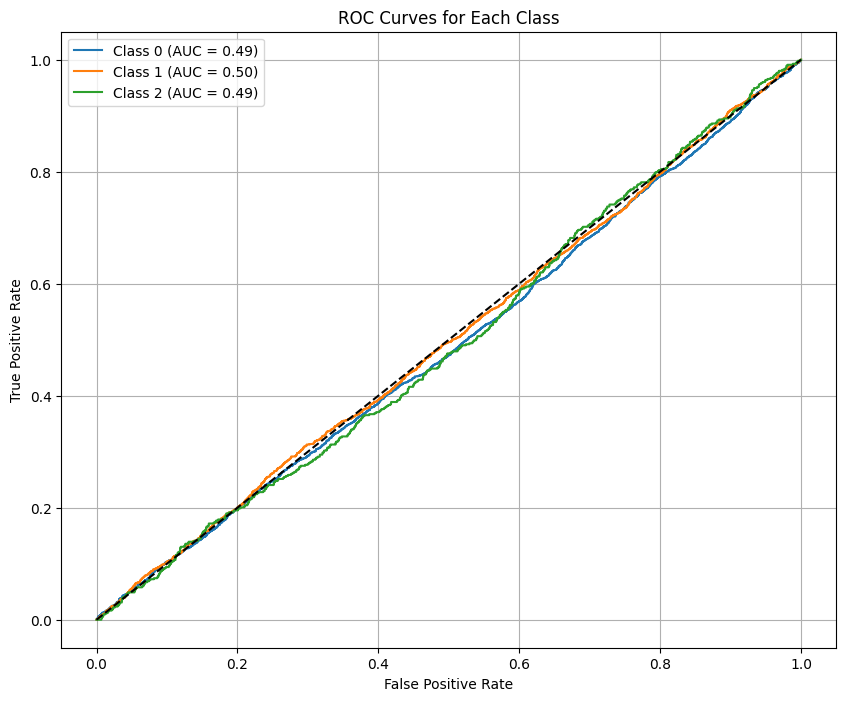

In [ ]:
from scipy.stats import randint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Load dataset
cleaned_dataset_path = '/content/drive/My Drive/ML/data.csv'
data = pd.read_csv(cleaned_dataset_path)

# Define features and target
features = [
    'Heart_Rate',
    'Blood_Pressure_Systolic',
    'Blood_Pressure_Diastolic',
    'Skin_Temperature',
    'Respiration_Rate',
    'Sleep_Duration',
    'Activity_Levels',
    'Mood',
    'Stress_Level',
    'Resilience_Factors'
]
target = 'Mental_Health_Status'

# Data preparation
X = data[features]  # Corrected from 'cleaned_data' to 'data'
y = data[target]    # Corrected from 'cleaned_data' to 'data'

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # This ensures balanced classes in both train and test sets
)

# Enhanced parameter grid with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(200, 1000),  # Increased minimum estimators
    'max_depth': [None] + list(range(10, 70, 5)),  # Extended depth range
    'min_samples_split': randint(2, 30),  # Extended split range
    'min_samples_leaf': randint(1, 15),   # Extended leaf range
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],  # Removed None to ensure class balance
    'criterion': ['gini', 'entropy']  # Added criterion choice
}

# Initialize RandomizedSearchCV with better parameters
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=100),
    param_distributions=param_dist,
    n_iter=100,  # Increased number of iterations
    cv=5,
    scoring='balanced_accuracy',  # Changed to balanced accuracy
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit and get best model
print("Training model with RandomizedSearchCV...")
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_

# Feature importance analysis
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Mental Health Prediction")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Model evaluation
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print comprehensive metrics
print("\nBest Parameters:", random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC curves
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.grid(True)
plt.show()

# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, n_jobs=-1,
    scoring='balanced_accuracy'
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Cross-validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Balanced Accuracy Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate and save detailed metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Weighted Precision': precision_score(y_test, y_pred, average='weighted'),
    'Weighted Recall': recall_score(y_test, y_pred, average='weighted'),
    'Weighted F1': f1_score(y_test, y_pred, average='weighted'),
    'Macro F1': f1_score(y_test, y_pred, average='macro'),
    'Cross-validation Score': cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
}

# Class-wise metrics
class_metrics = {}
for i in range(n_classes):
    class_metrics[f'Class {i}'] = {
        'Precision': precision_score(y_test, y_pred, average=None)[i],
        'Recall': recall_score(y_test, y_pred, average=None)[i],
        'F1': f1_score(y_test, y_pred, average=None)[i],
        'ROC AUC': roc_auc[i]
    }

# Print final results
print("\nFinal Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nClass-wise Performance Metrics:")
for class_name, class_metric in class_metrics.items():
    print(f"\n{class_name}:")
    for metric_name, value in class_metric.items():
        print(f"{metric_name}: {value:.4f}")

# Calculate and print confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nConfusion Matrix (Percentages):")
print(pd.DataFrame(cm_normalized.round(3) * 100,
                  columns=[f'Predicted {i}' for i in range(n_classes)],
                  index=[f'Actual {i}' for i in range(n_classes)]))

# Save results
results = {
    'best_model': best_rf_model,
    'feature_importance': dict(zip(features, importances)),
    'metrics': metrics,
    'class_metrics': class_metrics,
    'best_params': random_search.best_params_,
    'confusion_matrix': cm,
    'confusion_matrix_normalized': cm_normalized
}